## Titanic - Machine Learning from Disaster

*Source: **Kaggle** https://www.kaggle.com/c/titanic/overview*

On April 15, 1912 the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this challenge, I will build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data.

#### Data dictionary

- *survival* - Survival (0=No, 1=Yes),
- *pclass* - Ticket class (1 = 1st, 2 = 2nd, 3 = 3rd),
- *sex* - Sex,
- *age* - Age in years
- *sibsp* - siblings / spouse aboard the Titanic
- *parch* - parents / children aboard the Titanic
- *ticket* - Ticket number
- *fare* - Passenger fare
- *cabin* - Cabin number
- *embarked* - Port of Embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)

---

### Importing libraries and uploading data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [208]:
data_train = pd.read_csv('train.csv')

---
## Data cleaning

In [209]:
data_train.set_index('PassengerId', inplace=True)
data_train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [210]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


### Feature *Sex*

First of all I have decided to transform string feature 'Sex' to numeric, binary, as it's easier to analyze. 

In [211]:
data_train['Sex'] = pd.get_dummies(data_train['Sex'], drop_first=True)
# male=1, female = 0

### Feature *Cabin*

There is around 77% missing data in feature *Cabin*, therefore it will be deleted from *data_train*.

In [212]:
#data_train.drop('Cabin', axis=1, inplace=True)

In [213]:
data_train['Cabin'].fillna('N', inplace=True)
data_train['Cabin'] = data_train['Cabin'].str[0]
data_train['Cabin']

PassengerId
1      N
2      C
3      N
4      C
5      N
      ..
887    N
888    B
889    N
890    C
891    N
Name: Cabin, Length: 891, dtype: object

In [214]:
ticket_and_cabin = data_train[data_train.Cabin != 'N'][["Ticket", "Cabin"]].drop_duplicates().set_index("Ticket").to_dict()["Cabin"]
data_train["Cabin"] = data_train.apply(lambda row: ticket_and_cabin.get(row.Ticket, 'N'), axis=1)

In [215]:
data_train["Cabin"] = data_train["Cabin"].apply(lambda x: 'A' if x=='T' else x)

### Feature *Embarked*

*Embarked* is missing only 2 observation. It will be filled with port 'C'. 
There are few reasons for that:
1. These persons have the same ticket so they probably embarked at the same port. 
2. They belong to first class and ticket class (*Pclass*) is correlated with port of embarkation (*Embarked*) so as *Fare*.

In [216]:
data_train[data_train['Embarked'].isna()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
62,1,1,"Icard, Miss. Amelie",0,38.0,0,0,113572,80.0,B,NaN
830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",0,62.0,0,0,113572,80.0,B,NaN


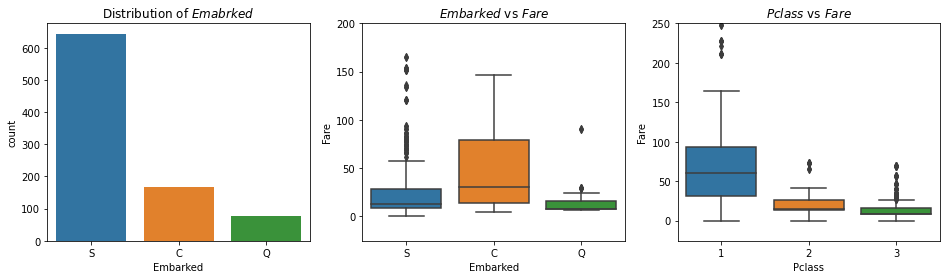

In [217]:
fig, ax = plt.subplots(1,3, figsize=(16,4))
sns.countplot(data=data_train, x='Embarked', ax=ax[0])
sns.boxplot(data=data_train, y='Fare', x='Embarked', ax=ax[1])
ax[1].set_ylim(top=200)
sns.boxplot(data=data_train, y='Fare', x='Pclass', ax=ax[2])
ax[2].set_ylim(top=250)
ax[0].set_title('Distribution of $\it{Emabrked}$')
ax[1].set_title('$\it{Embarked}$ vs $\it{Fare}$')
ax[2].set_title('$\it{Pclass}$ vs $\it{Fare}$');

In [218]:
# Filling missing data
data_train['Embarked'] = data_train['Embarked'].fillna('C')

### Feature *Age*

Feature *Age* is missing 177 observations. It can be valuable feature therefore it won't be removed from the dataframe. There is too many missing data to delete incomplete rows therefore I will fill out missing information.

Data will be filled out based on mean value of *Age* in each *Pclass*.

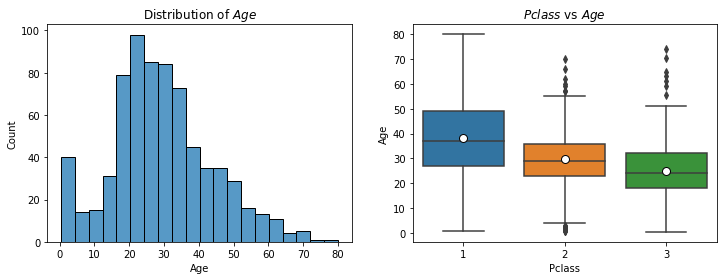

In [219]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
sns.histplot(data=data_train, x='Age', ax=ax[0])
sns.boxplot(data=data_train, y='Age', x='Pclass', ax=ax[1],
            showmeans=True,
            meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                       "markersize":"8"})
ax[0].set_title('Distribution of $\it{Age}$')
ax[1].set_title('$\it{Pclass}$ vs $\it{Age}$');


In [220]:
data_train['Age'] = data_train.groupby('Pclass')['Age'].transform(lambda value: value.fillna(value.mean()))

---

In [221]:
data_train.describe()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,0.647587,29.292875,0.523008,0.381594,32.204208
std,0.486592,0.836071,0.477990,13.210527,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,22.000000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,1.000000,26.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,1.000000,37.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,1.000000,80.000000,8.000000,6.000000,512.329200


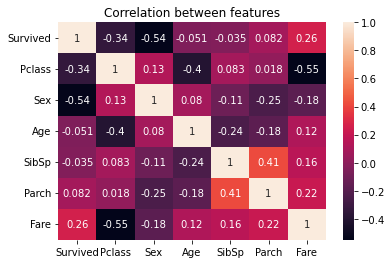

In [222]:
sns.heatmap(data = data_train.corr(), annot=True)
plt.title('Correlation between features');

---
### Preparation data for the model

Separating data for features and label:

In [223]:
y = data_train['Survived']
X = data_train.drop('Survived', axis=1)

Encoding categorical data:

In [224]:
my_dummies = pd.get_dummies(X[['Embarked', 'Cabin']], drop_first = True)

In [225]:
X.drop(['Embarked', 'Cabin'],axis=1, inplace=True)
final_X = pd.concat([X, my_dummies], axis = 1)

Removing features *Name* and *Ticket* as they are unique for each passenger and won't be very helpful with prediction.

In [226]:
final_X.drop(['Name', 'Ticket'],axis=1, inplace=True)

In [227]:
final_X.head(10)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_Q,Embarked_S,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_N
PassengerId,,,,,,,,,,,,,,,
1,3,1,22.00000,1,0,7.2500,0,1,0,0,0,0,0,0,1
2,1,0,38.00000,1,0,71.2833,0,0,0,1,0,0,0,0,0
3,3,0,26.00000,0,0,7.9250,0,1,0,0,0,0,0,0,1
4,1,0,35.00000,1,0,53.1000,0,1,0,1,0,0,0,0,0
5,3,1,35.00000,0,0,8.0500,0,1,0,0,0,0,0,0,1
6,3,1,25.14062,0,0,8.4583,1,0,0,0,0,0,0,0,1
7,1,1,54.00000,0,0,51.8625,0,1,0,0,0,1,0,0,0
8,3,1,2.00000,3,1,21.0750,0,1,0,0,0,0,0,0,1
9,3,0,27.00000,0,2,11.1333,0,1,0,0,0,0,0,0,1


---
### Creating model

In [228]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [229]:
X_train, X_test, y_train, y_test = train_test_split(final_X, y, test_size=0.25, random_state=101)

In [230]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [231]:
log_model = LogisticRegression(solver='saga',max_iter=5000)

penalty = ['l1', 'l2', 'elasticnet']
l1_ratio = [.1,.5,.7,.95,.99,1]
C = np.logspace(1,10,20)

grid_model = GridSearchCV(log_model,param_grid={'penalty':penalty, 'C':C,'l1_ratio':l1_ratio})

In [232]:
grid_model.fit(X_train_scaled,y_train)

C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'.

C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'.

C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'.

C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'.

C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'.

C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'.

C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'.

C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'.

C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'.

C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'.

C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'.

C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'.

C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'.

C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'.

C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'.

C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'.

C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'.

C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'.

C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'.

C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'.

C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'.

C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'.

C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'.

C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'.

C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'.

C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'.

C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'.

C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'.

C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'.

C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'.

GridSearchCV(estimator=LogisticRegression(max_iter=5000, solver='saga'),
             param_grid={'C': array([1.00000000e+01, 2.97635144e+01, 8.85866790e+01, 2.63665090e+02,
       7.84759970e+02, 2.33572147e+03, 6.95192796e+03, 2.06913808e+04,
       6.15848211e+04, 1.83298071e+05, 5.45559478e+05, 1.62377674e+06,
       4.83293024e+06, 1.43844989e+07, 4.28133240e+07, 1.27427499e+08,
       3.79269019e+08, 1.12883789e+09, 3.35981829e+09, 1.00000000e+10]),
                         'l1_ratio': [0.1, 0.5, 0.7, 0.95, 0.99, 1],
                         'penalty': ['l1', 'l2', 'elasticnet']})

In [233]:
grid_model.best_params_

{'C': 10.0, 'l1_ratio': 0.1, 'penalty': 'l1'}

In [234]:
log_model = LogisticRegression(solver='saga',max_iter=5000, penalty = 'l1', l1_ratio=0.1, C=10)
log_model.fit(X_train_scaled, y_train)
log_model.coef_

C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


array([[-0.81758719, -1.33966567, -0.62318661, -0.38725513, -0.08736058,
         0.25958348, -0.03273243, -0.19008383,  0.21993513, -0.11521604,
         0.21712561,  0.25670284,  0.16883605, -0.04415465,  0.06382088]])

---
### Vizualization of feature importances

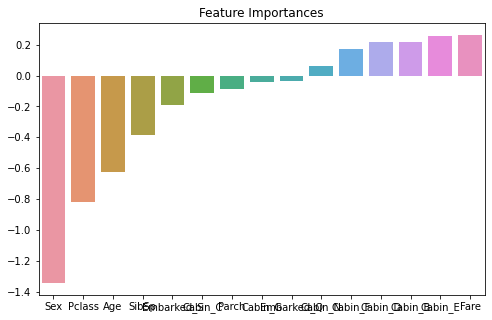

In [235]:
fig = plt.figure(figsize = (8,5))
coef_log_model = pd.Series(log_model.coef_[0], index=X_train.columns).sort_values()
sns.barplot(y=coef_log_model.values, x=coef_log_model.index)
plt.title('Feature Importances');

---
### Model Performance Evaluation

In [91]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report

In [236]:
y_predict=grid_model.predict(X_test_scaled)

C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


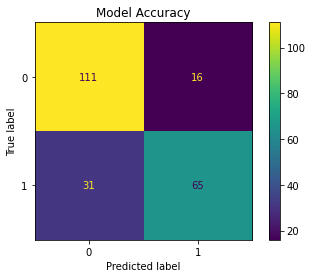

In [237]:
plot_confusion_matrix(grid_model, X_test_scaled, y_test)
plt.title('Model Accuracy');

In [238]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.78      0.87      0.83       127
           1       0.80      0.68      0.73        96

    accuracy                           0.79       223
   macro avg       0.79      0.78      0.78       223
weighted avg       0.79      0.79      0.79       223



C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


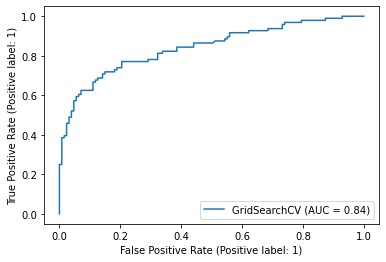

In [239]:
from sklearn.metrics import plot_roc_curve
plot_roc_curve(grid_model, X_test_scaled, y_test);

---
### Implementation of all data to the model

In [240]:
log_model_final = LogisticRegression(solver='saga',max_iter=5000, penalty = 'l1', l1_ratio=0.1, C=10)
log_model_final.fit(final_X, y)

C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


LogisticRegression(C=10, l1_ratio=0.1, max_iter=5000, penalty='l1',
                   solver='saga')

---
### Prediction of new data

In [241]:
df_test = pd.read_csv('test.csv')

In [242]:
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


### Adjusting data so it fits to the created model.

In [243]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [244]:
data_test = df_test.set_index('PassengerId')

**Filling out missing data**

In [245]:
data_test['Age'] = data_test.groupby('Pclass')['Age'].transform(lambda value: value.fillna(value.mean()))

In [246]:
data_test['Fare'] = data_test.groupby('Pclass')['Fare'].transform(lambda value: value.fillna(value.mean()))

In [247]:
data_test['Cabin'].fillna('N', inplace=True)
data_test['Cabin'] = data_test['Cabin'].str[0]

In [248]:
ticket_and_cabin_test = data_test[data_test.Cabin != 'N'][["Ticket", "Cabin"]].drop_duplicates().set_index("Ticket").to_dict()["Cabin"]
data_test["Cabin"] = data_test.apply(lambda row: ticket_and_cabin_test.get(row.Ticket, 'N'), axis=1)

**Encoding categorical data**

In [249]:
data_test['Sex'] = pd.get_dummies(data_test['Sex'], drop_first=True)

In [250]:
my_dummies_test = pd.get_dummies(data_test[['Embarked', 'Cabin']], drop_first = True)

In [251]:
data_test.drop(['Embarked', 'Cabin'],axis=1, inplace=True)
final_data_test = pd.concat([data_test, my_dummies_test], axis = 1)

In [252]:
final_data_test.drop(['Name', 'Ticket'], axis = 1, inplace=True)

In [253]:
final_data_test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_Q,Embarked_S,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_N
PassengerId,,,,,,,,,,,,,,,
892,3,1,34.5,0,0,7.8292,1,0,0,0,0,0,0,0,1
893,3,0,47.0,1,0,7.0000,0,1,0,0,0,0,0,0,1
894,2,1,62.0,0,0,9.6875,1,0,0,0,0,0,0,0,1
895,3,1,27.0,0,0,8.6625,0,1,0,0,0,0,0,0,1
896,3,0,22.0,1,1,12.2875,0,1,0,0,0,0,0,0,1


In [254]:
final_data_test_scaled = scaler.transform(final_data_test)
final_data_test_scaled

array([[ 0.8212948 ,  0.73669883,  0.42482624, ..., -0.11686341,
        -0.07761505,  0.55660032],
       [ 0.8212948 , -1.35740679,  1.38691169, ..., -0.11686341,
        -0.07761505,  0.55660032],
       [-0.38713015,  0.73669883,  2.54141422, ..., -0.11686341,
        -0.07761505,  0.55660032],
       ...,
       [ 0.8212948 ,  0.73669883,  0.73269358, ..., -0.11686341,
        -0.07761505,  0.55660032],
       [ 0.8212948 ,  0.73669883, -0.38117468, ..., -0.11686341,
        -0.07761505,  0.55660032],
       [ 0.8212948 ,  0.73669883, -0.38117468, ..., -0.11686341,
        -0.07761505,  0.55660032]])

### Prediction of new data

In [255]:
log_model_final.predict_proba(final_data_test_scaled)

C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


array([[0.60222943, 0.39777057],
       [0.09182214, 0.90817786],
       [0.58028754, 0.41971246],
       [0.71143317, 0.28856683],
       [0.08955877, 0.91044123],
       [0.71076903, 0.28923097],
       [0.04801318, 0.95198682],
       [0.72738087, 0.27261913],
       [0.06998189, 0.93001811],
       [0.78585339, 0.21414661],
       [0.71133144, 0.28866856],
       [0.67006996, 0.32993004],
       [0.02887954, 0.97112046],
       [0.73322411, 0.26677589],
       [0.01305156, 0.98694844],
       [0.07682808, 0.92317192],
       [0.57855223, 0.42144777],
       [0.69308279, 0.30691721],
       [0.09140688, 0.90859312],
       [0.07039942, 0.92960058],
       [0.69349023, 0.30650977],
       [0.70671832, 0.29328168],
       [0.06326454, 0.93673546],
       [0.6424728 , 0.3575272 ],
       [0.0239999 , 0.9760001 ],
       [0.75173932, 0.24826068],
       [0.02148738, 0.97851262],
       [0.69315838, 0.30684162],
       [0.56737996, 0.43262004],
       [0.77113761, 0.22886239],
       [0.

In [256]:
log_model_final.predict(final_data_test_scaled)

C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

### Saving predicted data

In [257]:
data_predic = pd.Series(log_model_final.predict(final_data_test_scaled))

C:\ProgramData\Miniconda3\envs\myPython\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [258]:
data_predic_final = pd.concat([df_test['PassengerId'], data_predic], axis = 1)
data_predic_final.rename(columns = {0 : 'Survived'}, inplace = True)

In [259]:
data_predic_final

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [260]:
data_predic_final.to_csv('data_predic_final.csv', index=False)